In [2]:
import pandas as pd
import numpy as np
import hwacctools.quantization.quant as q
from stim_lib.stimulus_gen import generate_qracc_inputs

files = {
    'binary': {
        'results/2b/adc_out_ams_binary.txt':'2b_binary',
        'results/4b/mac_out_ams_binary.txt':'4b_binary',
        'results/8b/mac_out_ams_binary.txt':'8b_binary',
    },
    'bipolar': {
        'results/2b/adc_out_ams_bipolar.txt':'2b_bipolar',
        'results/4b/mac_out_ams_bipolar.txt':'4b_bipolar',
        'results/8b/mac_out_ams_bipolar.txt':'8b_bipolar',
    }
}

arrs = {}

for bipbin, fdict in files.items():
    for filename, dictname in fdict.items():
        arrs[dictname] = np.loadtxt(filename).flatten()

# Normalize
        
params = {
    '2b_binary': {
        'wDimX': 32,
        'wDimY': 128,
        'xBatches': 10,
        'xTrits': 1,
        'outBits': 4,
        'seed': 0,
        'rangeBits': 5,
        'weight_mode': 'binary',
        'col_symmetric': False,
        'clip_output': True
    },
    '4b_binary': {
        'wDimX': 32,
        'wDimY': 128,
        'xBatches': 10,
        'xTrits': 3,
        'outBits': 8,
        'seed': 0,
        'weight_mode': 'binary',
        'col_symmetric': False,
        'clip_output': False
    },
    '8b_binary': {
        'wDimX': 32,
        'wDimY': 128,
        'xBatches': 10,
        'xTrits': 7,
        'outBits': 8,
        'seed': 0,
        'weight_mode': 'binary',
        'col_symmetric': False,
        'clip_output': False
    },
    '2b_bipolar': {
        'wDimX': 32,
        'wDimY': 128,
        'xBatches': 10,
        'xTrits': 1,
        'outBits': 4,
        'seed': 0,
        'rangeBits': 5,
        'weight_mode': 'bipolar',
        'col_symmetric': False,
        'clip_output': True
    },
    '4b_bipolar': {
        'wDimX': 32,
        'wDimY': 128,
        'xBatches': 10,
        'xTrits': 3,
        'outBits': 4,
        'seed': 0,
        'rangeBits': 6,
        'weight_mode': 'bipolar',
        'col_symmetric': False,
        'clip_output': False
    },
    '8b_bipolar': {
        'wDimX': 32,
        'wDimY': 128,
        'xBatches': 10,
        'xTrits': 7,
        'outBits': 8,
        'seed': 0,
        'weight_mode': 'bipolar',
        'col_symmetric': False,
        'clip_output': False
    }
}

refs = {}

for key, arr in arrs.items():
    w,x,wxb = generate_qracc_inputs(**params[key])
    refs[key] = wxb.T[::-1].T.flatten()

# Normalize
    
for key, arr in arrs.items():
    scale = refs[key].max()
    refs[key] = refs[key] / scale
    arrs[key] = arrs[key] / scale

[STIM_GEN] Generating random weights
[STIM_GEN] Generating random weights
[STIM_GEN] Generating random weights
[STIM_GEN] Generating random weights
[STIM_GEN] Generating random weights
[STIM_GEN] Generating random weights


In [3]:
df = pd.DataFrame() 

for key, value in arrs.items():
    df[key] = arrs[key]

df = df.melt()

# Split variable column
df[['bitwidth', 'type']] = df['variable'].str.split('_', expand=True)
df['actual'] = df['value']

df.drop(columns=['variable','value'], inplace=True)

rdf = pd.DataFrame()

for key, value in refs.items():
    rdf[key] = refs[key]

rdf = rdf.melt()

df['reference'] = rdf['value']
df['error'] = df['actual'] - df['reference']

In [4]:
# SNR Computations
snrs = {}
for key, value in refs.items():
    snrs[key] = arrs[key].var() / (arrs[key]-refs[key]).var()
    snrs[key] = 10*np.log10(snrs[key])

snrs 

{'2b_binary': 20.128924267100427,
 '4b_binary': 18.11599874400561,
 '8b_binary': 18.812932362062703,
 '2b_bipolar': 21.03012406977669,
 '4b_bipolar': 15.404609301563653,
 '8b_bipolar': 16.322990084254307}

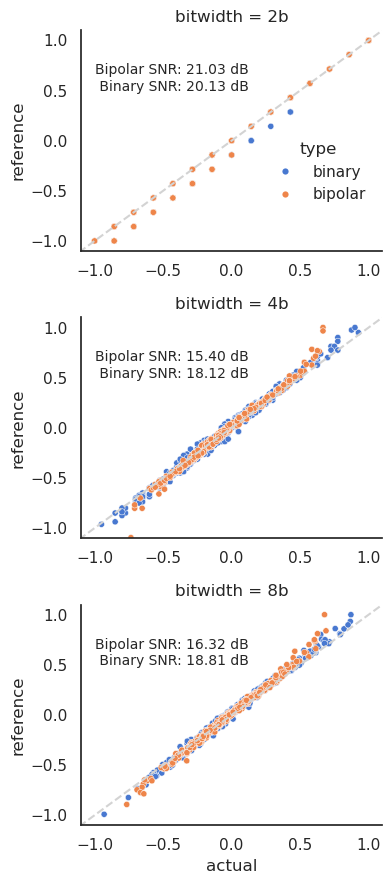

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
# sns.set_theme()
sns.set_theme(style='white',palette='muted')

rel = sns.relplot(df,x='actual',y='reference',row='bitwidth',hue='type',kind='scatter',s=20,facet_kws={'sharex':False,'sharey':False},
                  height=3,aspect=1, legend='auto')

for ax in rel.axes.flat:
    ax.plot([-1.1,1.1],[-1.1,1.1],transform=ax.transAxes,linestyle='--',color='lightgray')
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)

rel.axes.flat[0].text(-1,0.5,f'Bipolar SNR: {snrs['2b_bipolar']:.2f} dB \n Binary SNR: {snrs["2b_binary"]:.2f} dB',fontsize=10)
rel.axes.flat[1].text(-1,0.5,f'Bipolar SNR: {snrs['4b_bipolar']:.2f} dB \n Binary SNR: {snrs["4b_binary"]:.2f} dB',fontsize=10)
rel.axes.flat[2].text(-1,0.5,f'Bipolar SNR: {snrs['8b_bipolar']:.2f} dB \n Binary SNR: {snrs["8b_binary"]:.2f} dB',fontsize=10)

sns.move_legend(rel,'center right', bbox_to_anchor=(0.95,0.8))

plt.tight_layout()
plt.savefig('../images/scatters.svg')

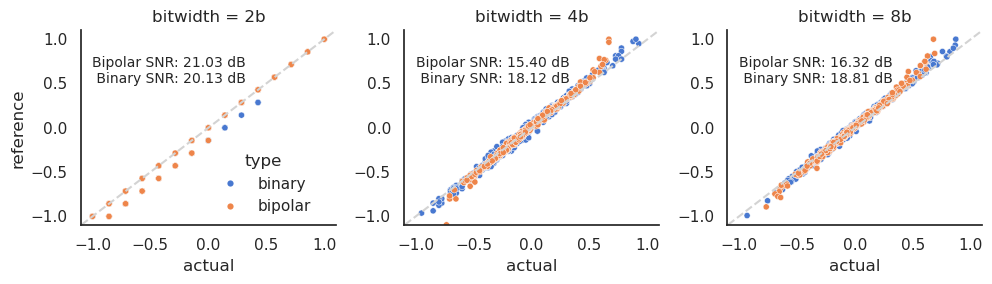

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='white',palette='muted')

rel = sns.relplot(df,x='actual',y='reference',col='bitwidth',hue='type',kind='scatter',s=20,facet_kws={'sharex':False,'sharey':False},
                  height=3,aspect=1, legend='auto')

for ax in rel.axes.flat:
    ax.plot([-1.1,1.1],[-1.1,1.1],transform=ax.transAxes,linestyle='--',color='lightgray')
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)

rel.axes.flat[0].text(-1,0.5,f'Bipolar SNR: {snrs['2b_bipolar']:.2f} dB \n Binary SNR: {snrs["2b_binary"]:.2f} dB',fontsize=10)
rel.axes.flat[1].text(-1,0.5,f'Bipolar SNR: {snrs['4b_bipolar']:.2f} dB \n Binary SNR: {snrs["4b_binary"]:.2f} dB',fontsize=10)
rel.axes.flat[2].text(-1,0.5,f'Bipolar SNR: {snrs['8b_bipolar']:.2f} dB \n Binary SNR: {snrs["8b_binary"]:.2f} dB',fontsize=10)

sns.move_legend(rel,'center right', bbox_to_anchor=(0.33,0.36))

plt.tight_layout()
plt.savefig('../images/scatters_hori.svg')

In [7]:
snr_df = pd.DataFrame(snrs,index=['SNR (dB)'])
snr_df = snr_df.melt()
# split variable column
snr_df[['bitwidth', 'type']] = snr_df['variable'].str.split('_', expand=True)
snr_df.drop(columns=['variable'], inplace=True)
snr_df['SNR (dB)'] = snr_df['value']
snr_df.drop(columns=['value'], inplace=True)
snr_df

,bitwidth,type,SNR (dB)
0,2b,binary,20.128924
1,4b,binary,18.115999
2,8b,binary,18.812932
3,2b,bipolar,21.030124
4,4b,bipolar,15.404609
5,8b,bipolar,16.322990


In [8]:

gops = snrs
gops['2b_bipolar'] = 410
gops['4b_bipolar'] = 410/3
gops['8b_bipolar'] = 410/7
gops['2b_binary'] = 410
gops['4b_binary'] = 410/3
gops['8b_binary'] = 410/7

gops_df = pd.DataFrame(gops,index=['GOPs'])
gops_df = gops_df.melt()
# split variable column
gops_df[['bitwidth', 'type']] = gops_df['variable'].str.split('_', expand=True)
gops_df.drop(columns=['variable'], inplace=True)
gops_df['GOPs'] = gops_df['value']
gops_df.drop(columns=['value'], inplace=True)
gops_df
snr_df['GOPs'] = gops_df['GOPs']

<Axes: xlabel='bitwidth', ylabel='SNR (dB)'>

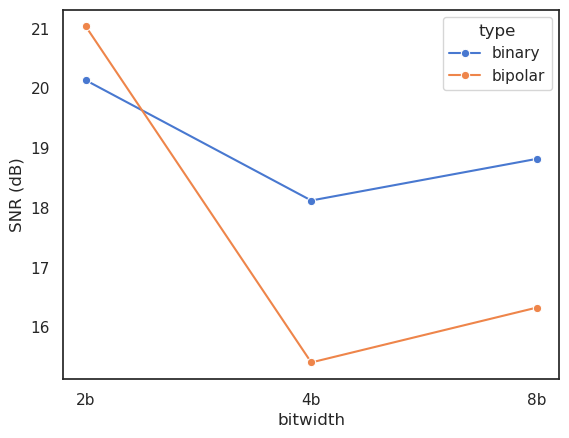

In [9]:
sns.lineplot(data=snr_df,x='bitwidth',y='SNR (dB)',hue='type',marker='o')